<a href="https://colab.research.google.com/github/AmrMomtaz/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition (SER)

## Installation and importing the data 

In this section all the project dependencies will be installed and we will import the data. You can find the dataset <a href="https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en">here</a>
You **MUST** import your kaggle API token to clone the data.

In [1]:
%%capture
# Cloning data
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
! unzip /content/speech-emotion-recognition-en.zip
! rm /content/speech-emotion-recognition-en.zip
! rm -rf /content/Ravdess
! rm -rf /content/Savee
! rm -rf /content/Tess

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import librosa, librosa.display
from IPython.core.display import display
import matplotlib.pyplot as plt
import IPython
import torch
from torch import nn
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import random
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

# Defining constants
SAMPLE_RATE = 22050 # Sample rate of the signal
NUM_SAMPLES = 88200 # Number of samples for each audio (2.5*22050)(2.5 secs)
FIG_SIZE = (9,6)

# Running GPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [2]:
# getting audio paths
crema_files = !ls /content/Crema
audio_df = []
for line in crema_files:
  for audio in line.split():
    path = '/content/Crema/'+audio
    label = audio.split('_')[2]
    duration = librosa.get_duration(filename=path)
    audio_df.append((path,duration,label))
audio_df = pd.DataFrame(audio_df,columns = ['Path','Duration','Label'])
audio_df.describe()

,Duration
count,7442.000000
mean,2.542884
std,0.505979
min,1.267937
25%,2.202187
50%,2.502500
75%,2.836187
max,5.005000


In [3]:
# Spliting and shuffling data
ANG,DIS,FEA,HAP,NEU,SAD = [],[],[],[],[],[]
sentiment_dict = {'ANG':ANG,'DIS':DIS,'FEA':FEA,'HAP':HAP,
                  'NEU':NEU,'SAD':SAD}
for label , frame in audio_df.groupby('Label'):
  sentiment_dict[label].append(list(frame.Path.values))
ANG,DIS,FEA,HAP,NEU,SAD = ANG[0],DIS[0],FEA[0],HAP[0],NEU[0],SAD[0]

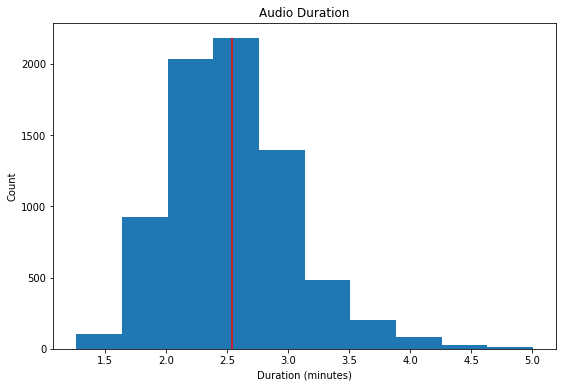

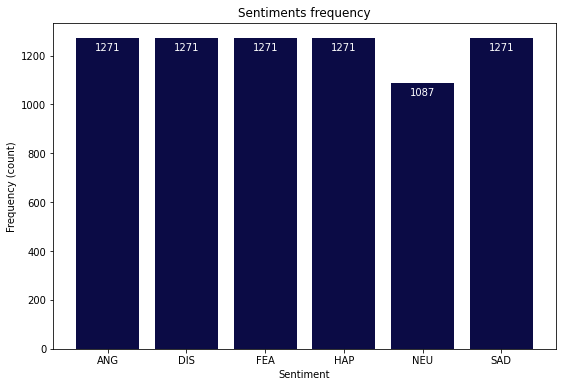

In [ ]:
#@title
# Duration histogram
plt.figure(figsize=FIG_SIZE)
plt.title('Audio Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.vlines(audio_df.Duration.mean(),0,2180,color = 'red')
plt.hist(audio_df['Duration'])
plt.show()
print('')
# Sentiments Bar chart
x,y = list(),list()
for group,frame in audio_df.groupby('Label'):
  x.append(group)
  y.append(len(frame))
plt.figure(figsize=FIG_SIZE)
plt.bar(x,y,color = (0.043,0.043,0.27))
plt.text(plt.xticks()[0][0],y[0]-50,y[0], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][1],y[1]-50,y[1], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][2],y[2]-50,y[2], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][3],y[3]-50,y[3], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][4],y[4]-50,y[4], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][5],y[5]-50,y[5], ha = 'center' , color = 'white')
plt.xlabel('Sentiment')
plt.ylabel('Frequency (count)')
plt.title('Sentiments frequency');

In [4]:
# Function which plots waveform  and loads the audio for listening
def visualize_audio(audio_path):
  signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE)
  # Plotting waveform
  plt.figure(figsize=FIG_SIZE)
  librosa.display.waveplot(signal, sample_rate, alpha=0.8)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show();
  print('')
  # Plotting power spectrum
  fft = np.fft.fft(signal)
  spectrum = np.abs(fft)
  f = np.linspace(0, sample_rate, len(spectrum))
  left_spectrum = spectrum[:int(len(spectrum)/2)]
  left_f = f[:int(len(spectrum)/2)]
  plt.figure(figsize=FIG_SIZE)
  plt.plot(left_f, left_spectrum, alpha=0.8)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title("Power spectrum")
  plt.show()
  print('')
  display(IPython.display.Audio(audio_path))

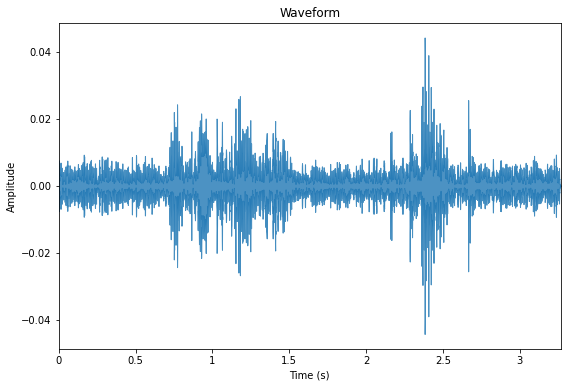

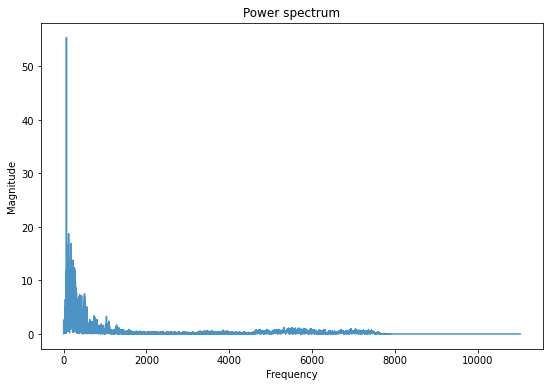

In [7]:
visualize_audio(SAD[900])

## Pre-processing data

In this section, We will preprocess and split the data. we'll provide two representation (feature spaces) of the data which we will feed to the neural network for training.
* Zero crossing rate (1D).
* Mel Sepctrogram (2D).

Finally, we'll split the data into 70% training and validation (66.5% for training and 3.5% for validation) and 30% for testing.

In [8]:
# Labels dictionay
labels_dict = {'ANG':torch.tensor(0, dtype=torch.long).to(device),
               'DIS':torch.tensor(1, dtype=torch.long).to(device),
               'FEA':torch.tensor(2, dtype=torch.long).to(device),
               'HAP':torch.tensor(3, dtype=torch.long).to(device),
               'NEU':torch.tensor(4, dtype=torch.long).to(device),
               'SAD':torch.tensor(5, dtype=torch.long).to(device) }

# Creating dataset class for preprocessing the data
class CremaDataset(Dataset):

    # data_list contains key as label and value is the audio path
    def __init__(self, data_list, transformation, target_sample_rate,
                 num_samples, device, librosa_lib):
      self.data_list = data_list
      if librosa_lib == False:
        self.transformation = transformation.to(device)
      else:
        self.transformation = transformation
      self.target_sample_rate = target_sample_rate
      self.num_samples = num_samples
      self.device = device
      self.librosa_lib = librosa_lib

    def __len__(self):
      return len(self.data_list)
 
    # Truncating long signals
    def _cut(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    # Padding short signals with zeros
    def _right_pad(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples:
          num_missing_samples = self.num_samples - length_signal
          last_dim_padding = (0, num_missing_samples)
          signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal

    # Resampling signal to make all signals have same target sample rate
    def _resample(self, signal, sr):
      if sr != self.target_sample_rate:
          resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(device)
          signal = resampler(signal)
      return signal

    # Mixing down signal (Reducing number of channels)
    def _mix_down(self, signal):
      if signal.shape[0] > 1:
          signal = torch.mean(signal, dim=0, keepdim=True)
      return signal

    def __getitem__(self, index):
      label = labels_dict[self.data_list[index][0]]
      signal, sr = torchaudio.load(self.data_list[index][1])
      signal = signal.to(self.device)
      signal = self._resample(signal, sr)
      signal = self._mix_down(signal)
      signal = self._cut(signal)
      signal = self._right_pad(signal)
      if self.librosa_lib == True:
        signal = torch.reshape(signal,(-1,))
        signal = signal.cpu().detach().numpy()
      signal = self.transformation(signal)
      if self.librosa_lib == True:
        #signal = torch.from_numpy(np.squeeze(signal, axis=0)).to(self.device)
        signal = torch.from_numpy(signal).to(self.device)
      return signal, label

In [9]:
# Transformation functions' constants
N_FFT = 1024 # Number of samples to compute fft
HOP_LENGTH = 512 # Number of samples to shift
N_MELS = 64 # Number of mels coefficients returned

# Returns zero crossing rate of a signal (1D)
zero_crossing_transformation = librosa.feature.zero_crossing_rate
# Returns mel spectrogram transformation (2D)
mel_spectrogram_transformation = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=64
)

In [10]:
# Splitting and strtifying the data
paths = [ANG,DIS,FEA,HAP,NEU,SAD]
labels = ['ANG','DIS','FEA','HAP','NEU','SAD']
train_data,validation_data,test_data=list(),list(),list()
# Train data
for i in range(len(paths)): 
  for path in paths[i][:int(len(paths[i])*0.665)]:
    train_data.append((labels[i],path))
random.shuffle(train_data)
# Validation data
for i in range(len(paths)): 
  for path in paths[i][int(len(paths[i])*0.665):int(len(paths[i])*0.7)]:
    validation_data.append((labels[i],path))
random.shuffle(validation_data)
# Test data
for i in range(len(paths)): 
  for path in paths[i][int(len(paths[i])*0.7):]:
    test_data.append((labels[i],path))
random.shuffle(test_data)

In [11]:
# This function returns the data loader for training,validation and test data
# dimension is either '1D' or '2D'
def get_data_loader(dimension,Batch_Size):
  if dimension == '1D' :
    train_dataset = CremaDataset(data_list = train_data,transformation = zero_crossing_transformation
                                  ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                                  device=device, librosa_lib = True)
    validation_dataset = CremaDataset(data_list = validation_data,transformation = zero_crossing_transformation
                                  ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                                  device=device, librosa_lib = True)
    test_dataset = CremaDataset(data_list = test_data,transformation = zero_crossing_transformation
                                  ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                                  device=device, librosa_lib = True)
  elif dimension == '2D' :
    train_dataset = CremaDataset(data_list = train_data,transformation = mel_spectrogram_transformation
                            ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                            device=device, librosa_lib = False)
    validation_dataset = CremaDataset(data_list = validation_data,transformation = mel_spectrogram_transformation
                                  ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                                  device=device, librosa_lib = False)
    test_dataset = CremaDataset(data_list = test_data,transformation = mel_spectrogram_transformation
                                  ,target_sample_rate = SAMPLE_RATE, num_samples = NUM_SAMPLES,
                                  device=device, librosa_lib = False)
  train_dataloader = DataLoader(train_dataset, batch_size=Batch_Size)
  validation_dataloader = DataLoader(validation_dataset, batch_size=Batch_Size)
  test_dataloader = DataLoader(test_dataset, batch_size=Batch_Size)
  return train_dataloader,validation_dataloader,test_dataloader

## Implementing VGG-19 architecture

In [12]:
# Defining VGG blocks
def conv_2D(input_channels,output_channels):
  return nn.Conv2d(
          in_channels=input_channels,
          out_channels=output_channels,
          kernel_size=3,
          stride=1,
          padding=1
      )

def VGG_block1(input_channels,output_channels):
  layer = nn.Sequential(
      conv_2D(input_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      conv_2D(output_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.MaxPool2d(kernel_size=2,stride=2)     
  )
  return layer

def VGG_block2(input_channels,output_channels):
  layer = nn.Sequential(
      
      conv_2D(input_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      conv_2D(output_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      conv_2D(output_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      conv_2D(output_channels,output_channels),
      #torch.nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.MaxPool2d(kernel_size=2,stride=2)     
  )
  return layer

def VGG_block3(input_channels,output_channels):
  layer =  nn.Sequential(
      nn.Linear(input_channels, output_channels),
      nn.ReLU(),
      nn.Dropout(0.5)
  )
  return layer

In [13]:
# Implementing the neural network
class VGG_19(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = VGG_block1(1,64)
    self.conv2 = VGG_block1(64,128)
    self.conv3 = VGG_block1(128,256)
    self.conv4 = VGG_block2(256,512)
    self.conv5 = VGG_block2(512,512)
    self.flatten = nn.Flatten()
    self.linear1 = VGG_block3(5120,4096)
    self.linear2 = VGG_block3(4096,4096)
    self.output_layer = nn.Linear(4096, 6)

  def forward(self, input_data):
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.output_layer(x)
    return x

In [17]:
vgg = VGG_19().to(device)
summary(vgg,(1,64,173))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 173]             640
              ReLU-2          [-1, 64, 64, 173]               0
            Conv2d-3          [-1, 64, 64, 173]          36,928
              ReLU-4          [-1, 64, 64, 173]               0
         MaxPool2d-5           [-1, 64, 32, 86]               0
            Conv2d-6          [-1, 128, 32, 86]          73,856
              ReLU-7          [-1, 128, 32, 86]               0
            Conv2d-8          [-1, 128, 32, 86]         147,584
              ReLU-9          [-1, 128, 32, 86]               0
        MaxPool2d-10          [-1, 128, 16, 43]               0
           Conv2d-11          [-1, 256, 16, 43]         295,168
             ReLU-12          [-1, 256, 16, 43]               0
           Conv2d-13          [-1, 256, 16, 43]         590,080
             ReLU-14          [-1, 256,

## Implementing simple VGG architecture

In [ ]:
class VGG_16(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(7680, 6)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        #x = self.dropout(x)
        x = self.linear(x)
        return x

In [ ]:
vgg = VGG_16().to(device)
summary(vgg,(1,64,173))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 175]             160
              ReLU-2          [-1, 16, 66, 175]               0
         MaxPool2d-3           [-1, 16, 33, 87]               0
            Conv2d-4           [-1, 32, 35, 89]           4,640
              ReLU-5           [-1, 32, 35, 89]               0
         MaxPool2d-6           [-1, 32, 17, 44]               0
            Conv2d-7           [-1, 64, 19, 46]          18,496
              ReLU-8           [-1, 64, 19, 46]               0
         MaxPool2d-9            [-1, 64, 9, 23]               0
           Conv2d-10          [-1, 128, 11, 25]          73,856
             ReLU-11          [-1, 128, 11, 25]               0
        MaxPool2d-12           [-1, 128, 5, 12]               0
          Flatten-13                 [-1, 7680]               0
           Linear-14                   

## Training model

In [16]:
# Training constants
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
EPOCHS = 100
PATIENCE = 10
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/SER/'
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimiser = torch.optim.Adam(vgg.parameters(),lr=LEARNING_RATE)
# Data loaders
train_dataloader,validation_dataloader,test_dataloader = get_data_loader('2D',BATCH_SIZE)

In [14]:
# Defining some functions
def predict(inputs):
  return torch.argmax(inputs,dim=1)

def calculate_accuracy(predicted,true_labels):
  accuracy = 0
  for i in range(predicted.shape[0]):
    if predicted[i] == true_labels[i]:
      accuracy += 1
  return accuracy

In [17]:
def train(model,train_dataloader,validation_dataloader,loss_fn,optimiser,device,epochs,patience,path):

  # Defining training loop variables
  best_validation_accuracy = 0
  current_patience = patience

  for i in range(epochs):
    print(f'Epoch {(i+1)} :')

    # Early stopping condition
    if current_patience <= 0:
      print('The patience is exceeded. Training is done')
      break
    
    # Training model
    model.train()
    average_train_loss = 0.0
    for input, target in train_dataloader:
      input, target = input.to(device), target.to(device)
      optimiser.zero_grad() # Resetting all gradients
      output = model(input) # Forward propagation
      loss = loss_fn(output, target) # Calculating loss
      loss.backward() # Back propagation
      optimiser.step() # Updating weights
      average_train_loss += loss.item()
    average_train_loss = (average_train_loss * 128) / 4947
    print(f'Training done || Training loss : {average_train_loss}') 

    # Testing model on validation data
    model.eval()
    average_validation_loss = 0.0
    total_accuracy = 0
    for input, target in validation_dataloader:
      with torch.no_grad():
        input, target = input.to(device), target.to(device)
        output = model(input)
        prediction = predict(output)
        total_accuracy += calculate_accuracy(prediction,target)
        loss = loss_fn(output, target)
        average_validation_loss += loss.item()
    average_validation_loss /= 2.01
    print(f'Validation done || Valitaion loss : {average_validation_loss}')
    print(f'Validation Accuracy : {(total_accuracy/258)}')
    fh = open(path+'loss.txt','a')
    fh.write(f'{average_train_loss} {average_validation_loss} {(total_accuracy/258)}\n')
    fh.close()

    # Saving model weigths if necessary
    if total_accuracy > best_validation_accuracy:
      print('Model has improved and the new weigths are being saved')
      torch.save(model.state_dict(), path+'SER.pth')
      print('New weigths are saved')
      best_validation_accuracy = total_accuracy
      current_patience = patience + 1
    current_patience -= 1
    print('__________________________________________________________')

In [22]:
train(vgg,train_dataloader,validation_dataloader,loss_fn,
      optimiser,device,EPOCHS,PATIENCE,MODEL_PATH)

Epoch 1 :
Training done || Training loss : 1.6941160283378816
Validation done || Valitaion loss : 2.2827256378249743
Validation Accuracy : 0.2441860465116279
Model has improved and the new weigths are being saved
New weigths are saved
__________________________________________________________
Epoch 2 :
Training done || Training loss : 1.5220912750595768
Validation done || Valitaion loss : 2.1324521866603874
Validation Accuracy : 0.3798449612403101
Model has improved and the new weigths are being saved
New weigths are saved
__________________________________________________________
Epoch 3 :
Training done || Training loss : 1.4740563850102097
Validation done || Valitaion loss : 2.0477888002917544
Validation Accuracy : 0.3798449612403101
__________________________________________________________
Epoch 4 :
Training done || Training loss : 1.4468739827473958
Validation done || Valitaion loss : 1.95266702281895
Validation Accuracy : 0.4069767441860465
Model has improved and the new weigths 

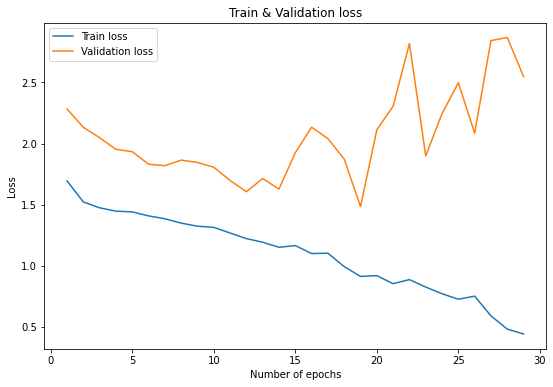

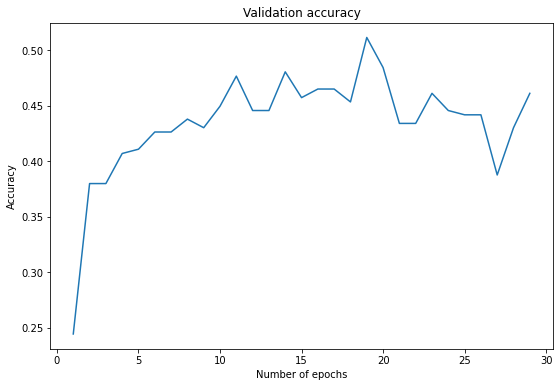

In [18]:
#@title
# Plotting the loss and accuracy
fh = open('/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/SER/loss.txt', 'r')
train_loss, validation_loss, validation_accuracy = list(), list(), list()
for line in fh.read().split('\n'):
    values = [float(x) for x in line.split(' ')]
    train_loss.append(values[0])
    validation_loss.append(values[1])
    validation_accuracy.append(values[2])
fh.close()
x = list(range(1, len(train_loss) + 1))
plt.figure(figsize=FIG_SIZE)
plt.title('Train & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.plot(x,train_loss,)
plt.plot(x,validation_loss)
plt.legend(['Train loss','Validation loss'])
plt.show()
plt.figure(figsize=FIG_SIZE)
plt.title('Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.plot(x,validation_accuracy)
plt.show();

## Testing model

In [19]:
WEIGHTS_PATH = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/SER/SER.pth'
# Loading model
model = VGG_19().to(device)
if device == 'cpu':
  state_dict = torch.load(WEIGHTS_PATH,map_location=torch.device('cpu'))
else:
  state_dict = torch.load(WEIGHTS_PATH)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
def test(model,test_dataloader) :
  print('Begin Testing ...')
  model.eval()
  average_testing_loss = 0
  full_stack = torch.tensor([],dtype=int).to(device)
  for input, target in test_dataloader:
    with torch.no_grad():
      input, target = input.to(device), target.to(device)
      output = model(input)
      prediction = predict(output)
      stacked = torch.stack((target,prediction),dim=1)
      full_stack = torch.cat((full_stack,stacked))
      loss = loss_fn(output, target)
      average_testing_loss += loss.item()
  average_testing_loss = (average_testing_loss * 128) / 2237
  print(f'Tetsing done with average loss = {average_testing_loss}')
  return full_stack

In [22]:
# Printing classification report
stakced_vector = test(model,test_dataloader)
y_true = stakced_vector[:,0].cpu().detach().numpy()
y_pred = stakced_vector[:,1].cpu().detach().numpy()
target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']
print(classification_report(y_true, y_pred, target_names=target_names,zero_division=True))

Begin Testing ...
Tetsing done with average loss = 1.5935467859437864
              precision    recall  f1-score   support

         ANG       0.72      0.61      0.66       382
         DIS       0.53      0.26      0.35       382
         FEA       0.37      0.38      0.37       382
         HAP       0.45      0.36      0.40       382
         NEU       0.49      0.49      0.49       327
         SAD       0.41      0.76      0.53       382

    accuracy                           0.48      2237
   macro avg       0.50      0.48      0.47      2237
weighted avg       0.50      0.48      0.47      2237



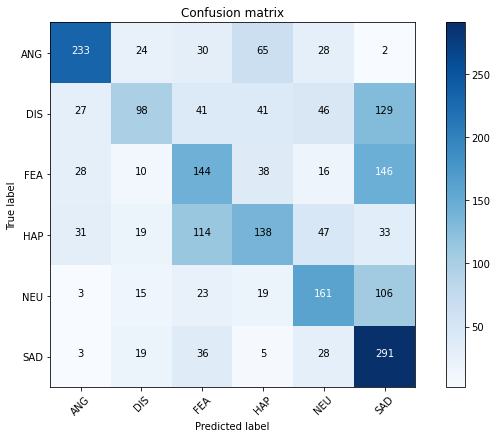

In [52]:
# Visualizing the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cmt = torch.zeros(6,6, dtype=torch.int64)
for p in stakced_vector:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
plt.figure(figsize=FIG_SIZE)
plot_confusion_matrix(cmt, target_names)